In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..") 
from src import load_realized_vol, build_har_features,load_earnings,load_implied_vol  # etc.
from src.load_data import load_close_to_close_realized_volatility
from src.features import fit_har_regression
from src.signals import compute_signal_matrix
from src.forecast import create_forecast
from src.signals import size_positions
from src.analytic_utils import filter_earnings,create_earnings_mask,filter_earnings_by_ticker, align_multiple


import pandas as pd
import pandas_market_calendars as mcal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import numpy as np


In [98]:
config = {
    "har_windows": {"short": 1, "medium": 5, "long": 21},
    "forecast_horizon": 5,
    "ranking_threshold": 0.9,
    "train_test_split_ratio": 0.7,
    "train_test_gap_days": 21,
}

In [102]:
realized = load_realized_vol()
earnings = load_earnings()
min_date,max_date = realized.index.min(), realized.index.max()
earnings_subset = filter_earnings(earnings, min_date, max_date)
earnings_subset = filter_earnings_by_ticker(earnings_subset, realized.columns)
earnings_mask = create_earnings_mask(realized, earnings_subset)
close_realized_vol, close_future_realized_vol = load_close_to_close_realized_volatility("../data/all_vols.csv", realized_vol_term=config["forecast_horizon"])

implied = load_implied_vol("../output/features_data.csv", earnings_subset)



har_1d, har_1w, har_1m = build_har_features(realized,term_1d=config["har_windows"]["short"], term_1w=config["har_windows"]["medium"], term_1m=config["har_windows"]["long"])
har_factors = fit_har_regression(realized, har_1d.shift(1), har_1w.shift(1), har_1m.shift(1), earnings_mask=earnings_mask)
forecast = create_forecast(har_1d, har_1w, har_1m, har_factors)

realized_adjusted = realized.copy()
realized_adjusted[earnings_mask] = forecast[earnings_mask]
har_1d, har_1w, har_1m = build_har_features(realized_adjusted, term_1d=config["har_windows"]["short"], term_1w=config["har_windows"]["medium"], term_1m=config["har_windows"]["long"])
har_factors = fit_har_regression(realized_adjusted, har_1d.shift(1), har_1w.shift(1), har_1m.shift(1), earnings_mask=earnings_mask)#just added this
forecast = create_forecast(har_1d, har_1w, har_1m, har_factors)
signal_matrix = compute_signal_matrix(forecast, implied) #both forecast and implied are as of today
positions = size_positions(signal_matrix, implied.loc[forecast.index], method='unit', threshold=0.0)



aligned_realized, aligned_implied,aligned_forecast, aligned_signal,aligned_positions= align_multiple(close_future_realized_vol, implied, forecast, signal_matrix, positions, align_columns=True)

/Users/stirlitz/ncGitHub/vol_forecast_project/vol_forecast/notebooks/../src/load_data.py:121: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_returns = df_prices.pct_change()


In [108]:
def split_train_test_multiple(*dfs, split_ratio=0.7, train_test_gap_days=21):
    # Explicitly extract sorted unique dates from the first DataFrame
    unique_dates = dfs[0].index.get_level_values(0).unique().sort_values()

    # Compute explicit split points
    split_point = int(len(unique_dates) * split_ratio)
    train_dates = unique_dates[:split_point]
    test_dates = unique_dates[split_point + train_test_gap_days:]

    train_dfs = []
    test_dfs = []

    for df in dfs:
        train_df = df[df.index.get_level_values(0).isin(train_dates)]
        test_df = df[df.index.get_level_values(0).isin(test_dates)]
        train_dfs.append(train_df)
        test_dfs.append(test_df)

    return train_dfs, test_dfs

In [107]:
train_dfs, test_dfs = split_train_test_multiple(
    aligned_realized,
    aligned_implied,
    aligned_forecast,
    aligned_signal,
    aligned_positions,
    aligned_vol_indeces,
    split_ratio=config["train_test_split_ratio"],
    train_test_gap_days=config["train_test_gap_days"]
)

(train_aligned_realized,
 train_aligned_implied,
 train_aligned_forecast,
 train_aligned_signal,
 train_aligned_positions,
 train_aligned_vol_indeces) = train_dfs

(test_aligned_realized,
 test_aligned_implied,
 test_aligned_forecast,
 test_aligned_signal,
 test_aligned_positions,
 test_aligned_vol_indeces) = test_dfs

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Function to prepare ranked classifier inputs
def create_classifier_inputs(forecast, implied, realized, vol_indeces, threshold=0.2, use_vol_indeces=False):
    # Compute cross-sectional daily ranks
    iv_rank = implied.rank(axis=1, pct=True)
    rv_rank = realized.rank(axis=1, pct=True)

    # Binary target: 1 if rank improvement > threshold
    y_binary = ((rv_rank - iv_rank) > threshold).stack().astype(int)

    X = (forecast - implied).stack().rename("signal")

    # Align indices
    common_idx = X.index.intersection(y_binary.index)
    #common_idx = common_idx.intersection(vol_indeces.index)
    #vol_indeces_aligned = vol_indeces.loc[common_idx]
    X_aligned = X.loc[common_idx]
    y_aligned = y_binary.loc[common_idx]

    # Align vol_indices by date (use level=0 of MultiIndex)
    dates = common_idx.get_level_values(0)
    vol_indeces_aligned = vol_indeces.reindex(dates).reset_index(drop=True)
    X_df=None
    if use_vol_indeces:
        X_df = pd.DataFrame({
            'signal': X.loc[common_idx].reset_index(drop=True),
            #'VIX': vol_indeces_aligned.iloc[:, 0],
            #'VVIX': vol_indeces_aligned.iloc[:, 1],
            #'VIX9D': vol_indeces_aligned.iloc[:, 2],
            'VIX_CLOSE_DIFF': vol_indeces_aligned.iloc[:, 3],
        })
    else:
        X_df = pd.DataFrame({
            'signal': X.loc[common_idx].reset_index(drop=True),
        })
    # Build X DataFrame with vol_indices
    #X_df = pd.DataFrame({
    #    'signal': X.loc[common_idx].reset_index(drop=True),
    #    'VIX': vol_indeces_aligned.iloc[:, 0],
    #    'VVIX': vol_indeces_aligned.iloc[:, 1],
    #    'VIX9D': vol_indeces_aligned.iloc[:, 2],
    #})

    # Prepare DataFrame
    #X_df = X_aligned.reset_index(drop=True).to_frame()
    # Add vol index columns to X_df
    #for col in vol_indeces_aligned.columns:
    #    X_df[col] = vol_indeces_aligned[col].reset_index(drop=True)

 
    y_series = y_aligned.reset_index(drop=True)

    return X_df, y_series

# Prepare training data
X_train, y_train = create_classifier_inputs(train_aligned_signal, train_aligned_implied, train_aligned_realized, train_aligned_vol_indeces, use_vol_indeces=True)

# Fit RandomForest Classifier
clf = RandomForestClassifier(max_depth=3, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Training performance
y_train_pred = clf.predict(X_train)
train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])

# Prepare test data
X_test, y_test = create_classifier_inputs(test_aligned_signal, test_aligned_implied, test_aligned_realized, test_aligned_vol_indeces, use_vol_indeces=True)

# Test performance
y_test_pred = clf.predict(X_test)
test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

# Reporting
print("Training ROC-AUC Score:", f"{train_auc:.4f}")
print("Test ROC-AUC Score:", f"{test_auc:.4f}")
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_test_pred))


Training ROC-AUC Score: 0.7023
Test ROC-AUC Score: 0.7142

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.98      0.24      0.39     35195
           1       0.24      0.98      0.39      8757

    accuracy                           0.39     43952
   macro avg       0.61      0.61      0.39     43952
weighted avg       0.83      0.39      0.39     43952



In [84]:
#aligned_vol_indeces["VIX_CLOSE"]=(aligned_vol_indeces["VIX_CLOSE"]-aligned_vol_indeces["VIX_CLOSE"].mean())/aligned_vol_indeces["VIX_CLOSE"].std()

X_test








,signal,VIX
0,-0.157504,-1.101240
1,-0.314287,-1.101240
2,-0.184217,-1.101240
3,-0.097495,-1.101240
4,-0.083451,-1.101240
...,...,...
43947,-0.213264,-1.514377
43948,-0.271124,-1.514377
43949,-0.246791,-1.514377
43950,-0.356467,-1.514377


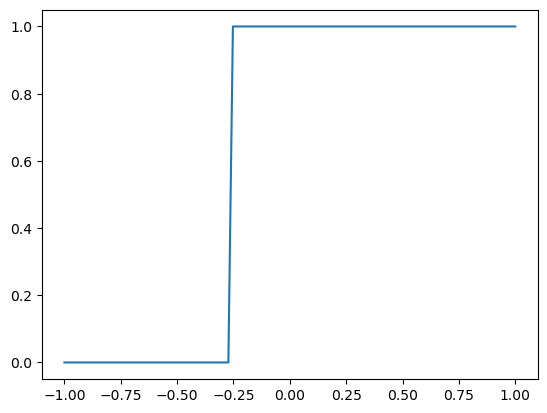

In [53]:
import matplotlib.pyplot as plt
x_line=np.linspace(-1,1,100)
x_line=pd.DataFrame(x_line,columns=["signal"])
y_line=clf.predict(x_line)

plt.plot(x_line,y_line)
plt.show()

In [19]:
x_line.rank(pct=True)

,signal
0,0.01
1,0.02
2,0.03
3,0.04
4,0.05
...,...
95,0.96
96,0.97
97,0.98
98,0.99


In [ ]:
def create_regressor_inputs(signal, implied, realized,voll):
    X = signal.stack().rename("signal")
    #y = (aligned_realized.loc[forecast.index]>aligned_implied.loc[forecast.index]).stack().astype(int).reset_index(drop=True)
    #y = (realized > implied).stack().astype(int)
    y = (realized - implied).stack()
    # Intersection of multi-indices
    common_idx = X.index.intersection(y.index)

    X_aligned = X.loc[common_idx]
    y_aligned = y.loc[common_idx]

    # Ready for modeling
    X_df = X_aligned.reset_index(drop=True).to_frame()
    y_series = y_aligned.reset_index(drop=True)
    return X_df, y_series

X_df, y_series = create_regressor_inputs(train_aligned_signal, train_aligned_implied, train_aligned_realized)

clf= RandomForestRegressor(max_depth=3).fit(X_df, y_series)
y_pred = clf.predict(X_df)
mse = mean_squared_error(y_series, y_pred)
mae = mean_absolute_error(y_series, y_pred)
r2 = r2_score(y_series, y_pred)


X_test_df, y_test_series = create_regressor_inputs(test_aligned_signal, test_aligned_implied, test_aligned_realized)
y_test_pred = clf.predict(X_test_df)
test_mse = mean_squared_error(y_test_series, y_test_pred)
test_mae = mean_absolute_error(y_test_series, y_test_pred)
test_r2 = r2_score(y_test_series, y_test_pred)
# Clearly print metrics
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

print(f"Test Mean Squared Error: {test_mse:.4f}")
print(f"Test Mean Absolute Error: {test_mae:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

In [5]:
import pandas as pd

def load_vol_indices():
    # File paths
    file_paths = {
        "VIX": "../data/VIX_History.csv",
        "VVIX": "../data/VVIX_History.csv",
        "VIX9D": "../data/VIX9D_History.csv"
    }

    dfs = {}
    for name, path in file_paths.items():
        df = pd.read_csv(path, parse_dates=['DATE'])
        df.set_index('DATE', inplace=True)
        df.rename(columns=lambda x: f"{name}_{x.strip().replace(' ', '_')}", inplace=True)
        dfs[name] = df

    # Combine into one dataframe
    combined_df = pd.concat(dfs.values(), axis=1)

    return combined_df

# Usage example
vol_indices_df = load_vol_indices()
vol_indices_df.head()


,VIX_OPEN,VIX_HIGH,VIX_LOW,VIX_CLOSE,VVIX_VVIX,VIX9D_OPEN,VIX9D_HIGH,VIX9D_LOW,VIX9D_CLOSE
DATE,,,,,,,,,
1990-01-02,17.24,17.24,17.24,17.24,NaN,NaN,NaN,NaN,NaN
1990-01-03,18.19,18.19,18.19,18.19,NaN,NaN,NaN,NaN,NaN
1990-01-04,19.22,19.22,19.22,19.22,NaN,NaN,NaN,NaN,NaN
1990-01-05,20.11,20.11,20.11,20.11,NaN,NaN,NaN,NaN,NaN
1990-01-08,20.26,20.26,20.26,20.26,NaN,NaN,NaN,NaN,NaN


In [85]:
import pandas as pd

def load_vol_indices():
    # File paths
    file_paths = {
        "VIX": "../data/VIX_History.csv",
        "VVIX": "../data/VVIX_History.csv",
        "VIX9D": "../data/VIX9D_History.csv"
    }

    dfs = {}
    for name, path in file_paths.items():
        df = pd.read_csv(path, parse_dates=['DATE'])
        df.set_index('DATE', inplace=True)
        df.rename(columns=lambda x: f"{name}_{x.strip().replace(' ', '_')}", inplace=True)
        dfs[name] = df

    # Combine into one dataframe
    combined_df = pd.concat(dfs.values(), axis=1)
    return combined_df

vol_indeces = load_vol_indices()
vol_indeces=vol_indeces[['VIX_CLOSE', 'VVIX_VVIX', 'VIX9D_CLOSE']]
vol_indeces=vol_indeces/100
vol_indeces.ffill(inplace=True) 

aligned_vol_indeces=vol_indeces.loc[aligned_realized.index]








In [94]:





aligned_vol_indeces.head()
aligned_vol_indeces["VIX_CLOSE_DIFF"]=aligned_vol_indeces.VIX_CLOSE.diff()
aligned_vol_indeces

,VIX_CLOSE,VVIX_VVIX,VIX9D_CLOSE,VIX_CLOSE_DIFF
2022-02-02,0.2209,1.1961,0.2160,NaN
2022-02-03,0.2435,1.2511,0.2411,0.0226
2022-02-04,0.2322,1.2489,0.2186,-0.0113
2022-02-07,0.2286,1.2413,0.2161,-0.0036
2022-02-08,0.2144,1.1886,0.2007,-0.0142
...,...,...,...,...
2023-12-22,0.1303,0.8862,0.1156,-0.0062
2023-12-26,0.1299,0.8887,0.1245,-0.0004
2023-12-27,0.1243,0.8622,0.1123,-0.0056
2023-12-28,0.1247,0.8669,0.1123,0.0004
